## Imports necessary libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

from resources.arabic_preprocessing import Arabic_preprocessing

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA

from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

## Reading Dataset

In [2]:
sample=pd.read_csv('data/joy_train.csv',header=None, names=['index', 'tweet','emotion','score'])
test_sample=pd.read_csv('data/joy_test.csv',header=None, names=['index', 'tweet','emotion','score'])

## Preprocess Tweets

In [3]:
prep = Arabic_preprocessing()
sample['tweet']=sample['tweet'].apply(lambda x : prep.preprocess_arabic_text(x))
test_sample['tweet']=test_sample['tweet'].apply(lambda x : prep.preprocess_arabic_text(x))

## Preparing training & test data (uni & bi-grams)

In [4]:
X = sample['tweet'].tolist()
y_train = sample['score'].tolist()
count_vect_uni = CountVectorizer(lowercase=False, token_pattern=r'\S+', ngram_range=(1, 1))
count_vect_bi = CountVectorizer(lowercase=False, token_pattern=r'\S+', ngram_range=(2, 2))
count_vect_uni_bi = CountVectorizer(lowercase=False, token_pattern=r'\S+', ngram_range=(1, 2))
count_vect_uni = count_vect_uni.fit(X)
count_vect_bi = count_vect_bi.fit(X)
count_vect_uni_bi = count_vect_uni_bi.fit(X)

X_train_count_uni = count_vect_uni.transform(X)
X_train_count_bi = count_vect_bi.transform(X)
X_train_count_uni_bi = count_vect_uni_bi.transform(X)

X_test = test_sample['tweet'].tolist()
y_test = test_sample['score'].tolist()
X_test_count_uni = count_vect_uni.transform(X_test)
X_test_count_bi = count_vect_bi.transform(X_test)
X_test_count_uni_bi = count_vect_uni_bi.transform(X_test)

## PCA

In [5]:
pca = PCA(n_components=1000)
X_train_count_uni_pca = pca.fit_transform(X_train_count_uni.toarray())
X_test_count_uni_pca = pca.transform(X_test_count_uni.toarray())
X_train_count_uni_bi_pca = pca.fit_transform(X_train_count_uni_bi.toarray())
X_test_count_uni_bi_pca = pca.transform(X_test_count_uni_bi.toarray())

#### TODO: try PLS

## train & evaluate method

In [6]:
def train_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train) # Train the model using the training sets
    y_pred = model.predict(X_test) # Make predictions using the testing set
    y_pred_train = model.predict(X_train)
    r2 = r2_score(y_test, y_pred)
    #r2_train = r2_score(y_train, y_pred_train)
    rmse = mean_squared_error(y_test, y_pred)
    #rmse_train = mean_squared_error(y_train, y_pred_train)
    #print("Train: R2 : {0:f}, RMSE : {1:f}".format( r2_train, rmse_train ) )
    print("Test: R2 : {0:f}, RMSE : {1:f}".format( r2, rmse ) )
    return (rmse, r2)

## Ridge

- tuning alpha parameter
- trying 4 different training data:
    -  uni-gram
    -  uni & bi-gram
    -  uni-gram with PCA (reduced dimensions = 1000)
    -  uni & bi-gram with PCA (reduced dimensions = 1000)

alpha = 0.1
Test: R2 : 0.112215, RMSE : 0.028241
Test: R2 : 0.144640, RMSE : 0.027210
Test: R2 : 0.176138, RMSE : 0.026208
Test: R2 : 0.241227, RMSE : 0.024137
alpha = 0.855172413793
Test: R2 : 0.175253, RMSE : 0.026236
Test: R2 : 0.219598, RMSE : 0.024825
Test: R2 : 0.203163, RMSE : 0.025348
Test: R2 : 0.284560, RMSE : 0.022759
alpha = 1.61034482759
Test: R2 : 0.199761, RMSE : 0.025457
Test: R2 : 0.245046, RMSE : 0.024016
Test: R2 : 0.212111, RMSE : 0.025064
Test: R2 : 0.291695, RMSE : 0.022532
alpha = 2.36551724138
Test: R2 : 0.212687, RMSE : 0.025045
Test: R2 : 0.259894, RMSE : 0.023544
Test: R2 : 0.215553, RMSE : 0.024954
Test: R2 : 0.295597, RMSE : 0.022408
alpha = 3.12068965517
Test: R2 : 0.224295, RMSE : 0.024676
Test: R2 : 0.269667, RMSE : 0.023233
Test: R2 : 0.216880, RMSE : 0.024912
Test: R2 : 0.298066, RMSE : 0.022329
alpha = 3.87586206897
Test: R2 : 0.238619, RMSE : 0.024220
Test: R2 : 0.276496, RMSE : 0.023016
Test: R2 : 0.217340, RMSE : 0.024897
Test: R2 : 0.299686, RMSE 

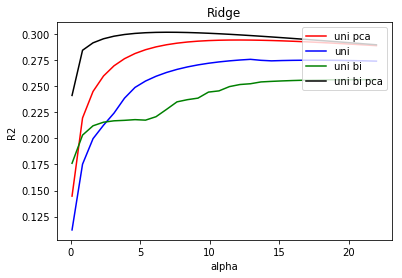

the best R^2 is 0.301850593434 with alpha=6.89655172414 and training data: uni & bi with PCA


In [9]:
r2_uni, r2_uni_pca, r2_uni_bi, r2_uni_bi_pca = [], [], [], []
max_r2, best_alpha, best_training_data = 0, 0, ''    
    
alphas = np.linspace(0.1,22,30)
for a in alphas:
    print('alpha = ' + str(a))
    # fit & evaluate uni-gram without pca
    model = linear_model.Ridge(alpha=a, random_state=seed)
    r2 = train_evaluate(model, X_train_count_uni, y_train, X_test_count_uni, y_test)[1]
    r2_uni.append(r2)
    if max_r2 < r2: max_r2, best_alpha, best_training_data = r2, a, 'uni'
    # fit & evaluate uni-gram with pca
    model = linear_model.Ridge(alpha=a, random_state=seed)
    r2 = train_evaluate(model, X_train_count_uni_pca, y_train, X_test_count_uni_pca, y_test)[1]
    r2_uni_pca.append(r2)
    if max_r2 < r2: max_r2, best_alpha, best_training_data = r2, a, 'uni with PCA'
    # fit & evaluate uni & bi-gram without pca
    model = linear_model.Ridge(alpha=a, random_state=seed)
    r2 = train_evaluate(model, X_train_count_uni_bi, y_train, X_test_count_uni_bi, y_test)[1]
    r2_uni_bi.append(r2)
    if max_r2 < r2: max_r2, best_alpha, best_training_data = r2, a, 'uni & bi'
    # fit & evaluate uni & bi-gram with pca
    model = linear_model.Ridge(alpha=a, random_state=seed)
    r2 = train_evaluate(model, X_train_count_uni_bi_pca, y_train, X_test_count_uni_bi_pca, y_test)[1]
    r2_uni_bi_pca.append(r2)
    if max_r2 < r2: max_r2, best_alpha, best_training_data = r2, a, 'uni & bi with PCA'

plt.plot(alphas,r2_uni_pca,'r', label='uni pca')
plt.plot(alphas,r2_uni,'b', label='uni')
plt.plot(alphas,r2_uni_bi,'g', label='uni bi')
plt.plot(alphas,r2_uni_bi_pca,'k', label='uni bi pca')
plt.legend(loc='upper right', numpoints = 1)
plt.xlabel('alpha')
plt.ylabel('R2')
plt.title('Ridge')
plt.show()

#print the best C and training data
print('the best R^2 is ' + str(max_r2) + ' with alpha=' + str(best_alpha) + ' and training data: ' + best_training_data)

#### Create the best Ridge model with the best alpha and training data obtained previously
#### Then calculate Pearson correlation between predicted and actual labels
See SemEval Evaluation: https://competitions.codalab.org/competitions/17751#learn_the_details-evaluation

In [11]:
best_ridge_model = linear_model.Ridge(alpha=6.89655172414, random_state=seed)
best_ridge_model.fit(X_train_count_uni_bi_pca, y_train) # Train the model using the training sets
y_pred = best_ridge_model.predict(X_test_count_uni_bi_pca) # Make predictions using the testing set
pearson = pearsonr(y_test, y_pred)
print('Pearson score for Ridge = ' + str(pearson[0]))

Pearson score for Ridge = 0.559065915533


## SVR

- tuning regularization parameter: C
- trying 4 different training data:
    -  uni-gram
    -  uni & bi-gram
    -  uni-gram with PCA (reduced dimensions = 1000)
    -  uni & bi-gram with PCA (reduced dimensions = 1000)

Test: R2 : 0.137624, RMSE : 0.027433
Test: R2 : 0.053944, RMSE : 0.030095
Test: R2 : 0.251331, RMSE : 0.023816
Test: R2 : 0.238741, RMSE : 0.024217
Test: R2 : 0.228779, RMSE : 0.024533
Test: R2 : 0.133649, RMSE : 0.027560
Test: R2 : 0.279522, RMSE : 0.022919
Test: R2 : 0.256448, RMSE : 0.023653
Test: R2 : 0.254203, RMSE : 0.023725
Test: R2 : 0.174591, RMSE : 0.026257
Test: R2 : 0.273988, RMSE : 0.023095
Test: R2 : 0.254515, RMSE : 0.023715
Test: R2 : 0.267474, RMSE : 0.023302
Test: R2 : 0.202733, RMSE : 0.025362
Test: R2 : 0.265082, RMSE : 0.023379
Test: R2 : 0.257166, RMSE : 0.023630
Test: R2 : 0.275818, RMSE : 0.023037
Test: R2 : 0.220924, RMSE : 0.024783
Test: R2 : 0.257722, RMSE : 0.023613
Test: R2 : 0.259832, RMSE : 0.023546
Test: R2 : 0.281199, RMSE : 0.022866
Test: R2 : 0.233400, RMSE : 0.024386
Test: R2 : 0.253218, RMSE : 0.023756
Test: R2 : 0.261325, RMSE : 0.023498
Test: R2 : 0.283445, RMSE : 0.022794
Test: R2 : 0.240382, RMSE : 0.024164
Test: R2 : 0.248692, RMSE : 0.023900
T

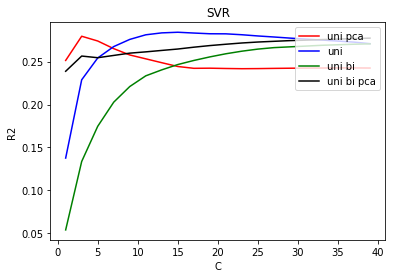

the best R^2 is 0.284177256792 with C=15and training data: uni


In [18]:
svr_uni, svr_uni_bi, svr_uni_pca, svr_uni_bi_pca = [], [], [], []
max_r2, best_C, best_training_data = 0, 0, ''

x = np.arange(1,40,2)
for c in x:
    print('C = ' + str(c))
    svr_uni.append(train_evaluate(SVR(C=c), X_train_count_uni, y_train, X_test_count_uni, y_test)[1])
    if max_r2 < svr_uni[-1]: max_r2, best_C, best_training_data = svr_uni[-1], c, 'uni'
    svr_uni_bi.append(train_evaluate(SVR(C=c), X_train_count_uni_bi, y_train, X_test_count_uni_bi, y_test)[1])
    if max_r2 < svr_uni_bi[-1]: max_r2, best_C, best_training_data = svr_uni_bi[-1], c, 'uni & bi'
    svr_uni_pca.append(train_evaluate(SVR(C=c), X_train_count_uni_pca, y_train, X_test_count_uni_pca, y_test)[1])
    if max_r2 < svr_uni_pca[-1]: max_r2, best_C, best_training_data = svr_uni_pca[-1], c, 'uni with PCA'
    svr_uni_bi_pca.append(train_evaluate(SVR(C=c), X_train_count_uni_bi_pca, y_train, X_test_count_uni_bi_pca, y_test)[1])
    if max_r2 < svr_uni_bi_pca[-1]: max_r2, best_C, best_training_data = svr_uni_bi_pca[-1], c, 'uni & bi with PCA'

#plotting R^2 for the 4 different data with different tuning C
plt.plot(x,svr_uni_pca,'r', label='uni pca')
plt.plot(x,svr_uni,'b', label='uni')
plt.plot(x,svr_uni_bi,'g', label='uni bi')
plt.plot(x,svr_uni_bi_pca,'k', label='uni bi pca')
plt.legend(loc='upper right', numpoints = 1)
plt.xlabel('C')
plt.ylabel('R2')
plt.title('SVR')
plt.show()

#print the best C and training data
#d = {'uni':max(svr_uni), 'uni & bi':max(svr_uni_bi), 'uni with pca':max(svr_uni_pca), 'uni & bi with pca':max(svr_uni_bi_pca)}
#best_param = max(zip(d.values(),d.keys()))
print('the best R^2 is ' + str(max_r2) + ' with C=' + str(best_C) + ' and training data: ' + best_training_data)

#### Create the best Ridge model with the best alpha and training data obtained previously
#### Then calculate Pearson correlation between predicted and actual labels
See SemEval Evaluation: https://competitions.codalab.org/competitions/17751#learn_the_details-evaluation

In [16]:
best_svr_model = SVR(C=15)
best_svr_model.fit(X_train_count_uni, y_train) # Train the model using the training sets
y_pred = best_svr_model.predict(X_test_count_uni) # Make predictions using the testing set
pearson = pearsonr(y_test, y_pred)
print('Pearson score for SVR = ' + str(pearson[0]))

Pearson score for SVR = 0.543664575669


## Ensemble : Random Forest

- tuning parameters: tree depth & number of trees (estimators)
- trying 4 different training data:
    -  uni-gram
    -  uni & bi-gram
    -  uni-gram with PCA
    -  uni & bi-gram with PCA

### TODO: to be tested
### TODO: add pearson score for the best model

depth: 1  estimators: 1000
Test: R2 : 0.132916, RMSE : 0.027583
Test: R2 : 0.132916, RMSE : 0.027583
Test: R2 : 0.150467, RMSE : 0.027025
Test: R2 : 0.135806, RMSE : 0.027491
depth: 2  estimators: 1000
Test: R2 : 0.216453, RMSE : 0.024926
Test: R2 : 0.216194, RMSE : 0.024934
Test: R2 : 0.172629, RMSE : 0.026320
Test: R2 : 0.126072, RMSE : 0.027801
depth: 3  estimators: 1000
Test: R2 : 0.247233, RMSE : 0.023946
Test: R2 : 0.246939, RMSE : 0.023956
Test: R2 : 0.178058, RMSE : 0.026147
Test: R2 : 0.128553, RMSE : 0.027722
depth: 4  estimators: 1000
Test: R2 : 0.258488, RMSE : 0.023588
Test: R2 : 0.258893, RMSE : 0.023575
Test: R2 : 0.179466, RMSE : 0.026102
Test: R2 : 0.138213, RMSE : 0.027414
depth: 7  estimators: 1000
Test: R2 : 0.273482, RMSE : 0.023111
Test: R2 : 0.274115, RMSE : 0.023091
Test: R2 : 0.173956, RMSE : 0.026277
Test: R2 : 0.156250, RMSE : 0.026841
depth: 10  estimators: 1000
Test: R2 : 0.276917, RMSE : 0.023002
Test: R2 : 0.278877, RMSE : 0.022940
Test: R2 : 0.175959, RM

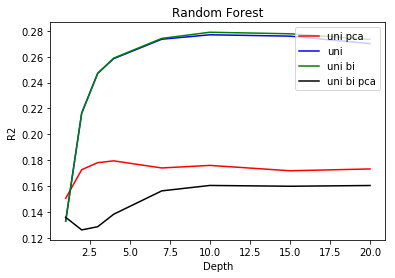

the best R^2 is 0.278877367079 with depth=10 and training data: uni & bi


In [9]:
r2_uni, r2_uni_bi, r2_uni_pca, r2_uni_bi_pca = [], [], [], []
max_r2, best_depth, best_training_data = 0, 0, ''

depth = [1,2,3,4,7,10,15,20]
#estimators = [10, 100, 1000]
for d in depth:
    #for e in estimators:
    print('depth: ' + str(d) + '  estimators: '+ str(1000))
    model = RandomForestRegressor(n_estimators=1000, max_depth=d, random_state=seed)
    r2_uni.append(train_evaluate(model, X_train_count_uni, y_train, X_test_count_uni, y_test)[1])
    if max_r2 < r2_uni[-1]: max_r2, best_depth, best_training_data = r2_uni[-1], d, 'uni'
    r2_uni_bi.append(train_evaluate(model, X_train_count_uni_bi, y_train, X_test_count_uni_bi, y_test)[1])
    if max_r2 < r2_uni_bi[-1]: max_r2, best_depth, best_training_data = r2_uni_bi[-1], d, 'uni & bi'
    r2_uni_pca.append(train_evaluate(model, X_train_count_uni_pca, y_train, X_test_count_uni_pca, y_test)[1])
    if max_r2 < r2_uni_pca[-1]: max_r2, best_depth, best_training_data = r2_uni_pca[-1], d, 'uni with PCA'
    r2_uni_bi_pca.append(train_evaluate(model, X_train_count_uni_bi_pca, y_train, X_test_count_uni_bi_pca, y_test)[1])
    if max_r2 < r2_uni_bi_pca[-1]: max_r2, best_depth, best_training_data = r2_uni_bi_pca[-1], d, 'uni & bi with PCA'

plt.plot(depth,r2_uni_pca,'r', label='uni pca')
plt.plot(depth,r2_uni,'b', label='uni')
plt.plot(depth,r2_uni_bi,'g', label='uni bi')
plt.plot(depth,r2_uni_bi_pca,'k', label='uni bi pca')
plt.legend(loc='upper right', numpoints = 1)
plt.xlabel('Depth')
plt.ylabel('R2')
plt.title('Random Forest')
plt.show()

print('the best R^2 is ' + str(max_r2) + ' with depth=' + str(best_depth) + ' and training data: ' + best_training_data)
        
# plt.figure(figsize = (12,6))
# plt.subplot(1, 2, 1)
# data_r2_uni = pd.DataFrame(np.array(r2_uni).reshape(len(depth),len(estimators)), index=depth, columns=estimators)
# ax = sns.heatmap(data_r2_uni, annot =True, fmt='.3g') #cmap="YlGnBu"
# plt.title('R^2 uni')
# plt.xlabel('# trees')
# plt.ylabel('depth')
# plt.subplot(1, 2, 2)
# data_r2_uni_pca = pd.DataFrame(np.array(r2_uni_pca).reshape(len(depth),len(estimators)), index=depth, columns=estimators)
# ax = sns.heatmap(data_r2_uni_pca, annot =True, fmt='.3g') #cmap="YlGnBu"
# plt.title('R^2 uni pca')
# plt.xlabel('# trees')
# plt.ylabel('depth')
# plt.tight_layout()
# plt.show()

# plt.subplot(1, 2, 1)
# data_r2_uni_bi = pd.DataFrame(np.array(r2_uni_bi).reshape(len(depth),len(estimators)), index=depth, columns=estimators)
# ax = sns.heatmap(data_r2_uni_bi, annot =True, fmt='.3g') #cmap="YlGnBu"
# plt.title('R^2 uni & bi')
# plt.xlabel('# trees')
# plt.ylabel('depth')
# plt.subplot(1, 2, 2)
# data_r2_uni_bi_pca = pd.DataFrame(np.array(r2_uni_bi_pca).reshape(len(depth),len(estimators)), index=depth, columns=estimators)
# ax = sns.heatmap(data_r2_uni_bi_pca, annot =True, fmt='.3g') #cmap="YlGnBu"
# plt.title('R^2 uni & bi pca')
# plt.xlabel('# trees')
# plt.ylabel('depth')
# plt.tight_layout()
# plt.show()

#### Create the best Random Forest model with the best depth and training data obtained previously
#### Then calculate Pearson correlation between predicted and actual labels
See SemEval Evaluation: https://competitions.codalab.org/competitions/17751#learn_the_details-evaluation

In [10]:
best_RF_model = RandomForestRegressor(n_estimators=1000, max_depth=best_depth, random_state=seed)
best_RF_model.fit(X_train_count_uni_bi, y_train) # Train the model using the training sets
y_pred = best_RF_model.predict(X_test_count_uni_bi) # Make predictions using the testing set
pearson = pearsonr(y_test, y_pred)
print('Pearson score for Random Forest = ' + str(pearson[0]))

Pearson score for Random Forest = 0.544613355443
